CSE 510 - Introduction to Reinforcement Learning 

Instructor: Alina Vereshchaka

#                                        Project 3: Policy Gradient

#### Author: 
Shwetasree Chowdhury

#### Department: 
Computer Science

#### UB Person ID: 
50296995



## Abstract

The goal of the project is to implement policy based algorithms to solve classic reinforcement learning problems on Open AI gym environments. 
The environment used is a classic open AI gym CartPole environment which has been solved using REINFORCE and ACTOR-CRITIC algorithm.

## * About the Gym AI Environment 

A detailed explanation of the gym environments can be found at: https://gym.openai.com/envs/#classic_control


### CartPole - v1

* It is a classic control environment where a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 

* The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. 

* A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center as illustrated above.

* This means better performing scenarios will run for longer duration, accumulating larger return.

* The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.)

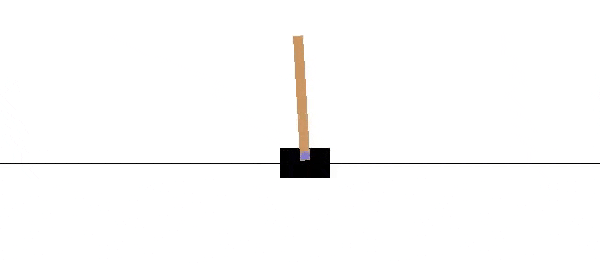

## Policy Gradient

There are two main types of RL methods:

* #### Value Based: 
They try to find or approximate the optimal value function, which is a mapping between an action and a value. The higher the value, the better the action. The most famous algorithm is Q learning and all its enhancements like Deep Q Networks, Double Dueling Q Networks, etc


* #### Policy-Based: 
Policy-Based algorithms like Policy Gradients and REINFORCE try to find the optimal policy directly without the Q -value as a middleman.


In policy-based methods, instead of learning a value function that tells us what is the expected sum of rewards given a state and an action, we learn directly the policy function that maps state to action (select actions without using a value function).

It means that we directly try to optimize our policy function π without worrying about a value function. We’ll directly parameterize π (select an action without a value function).

In essence, policy gradient methods update the probability distribution of actions so that actions with higher expected reward have a higher probability value for an observed state. We will assume discrete (finite) action space and a stochastic (non-deterministic) policy for this post.



### * The REINFORCE algorithm


REINFORCE is a Monte-Carlo variant of policy gradients (Monte-Carlo: taking random samples). The agent collects a trajectory τ of one episode using its current policy, and uses it to update the policy parameter. Since one full trajectory must be completed to construct a sample space, REINFORCE is updated in an off-policy way.

Pseudo code for REINFORCE :
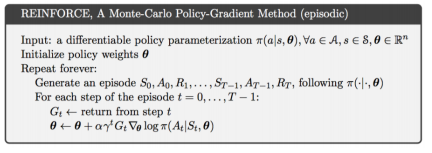


So, the flow of the algorithm is:

* Perform a trajectory roll-out using the current policy
* Store log probabilities (of policy) and reward values at each step
* Calculate discounted cumulative future reward at each step
* Compute policy gradient and update policy parameter
* Repeat first 4 steps

We use Monte Carlo because our tasks can be divided into episodes. We only calculate R at the end of the episode, we average all actions. Even if some of the actions taken were very bad, if our score is quite high, we will average all the actions as good.

In order to solve the above issue with REINFORCE algorithm, we would need to sample the outcome which would result in huge computation.

A2C algorithm steps in to resolve this issue.

### * The A2C algorithm

It is a hybrid between value-based algorithms and policy-based algorithms.

The principal idea is to split the model in two: one for computing an action based on a state and another one to produce the Q values of the action.

The actor takes as input the state and outputs the best action. It essentially controls how the agent behaves by learning the optimal policy (policy-based). The critic, on the other hand, evaluates the action by computing the value function (value based). Those two models participate in a game where they both get better in their own role as the time passes. The result is that the overall architecture will learn to train more efficiently than the two methods separately.

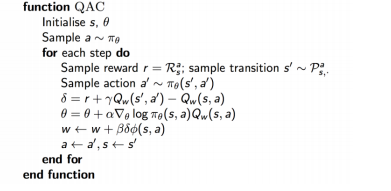

The training of the two networks is performed separately and it uses gradient ascent (to find the global maximum and not the minimum) to update both their weights. As time passes, the actor is learning to produce better and better actions (he is starting to learn the policy) and the critic is getting better and better at evaluating those actions. It is important to notice that the update of the weights happen at each step (TD Learning) and not at the end of the episode, opposed to policy gradients.


## Implementation

### Importing the librariers

In [1]:
import gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Part 1 - REINFORCE Implementation

### Defining the REINFORCE Agent class that implements Policy Gradient method. 

In [2]:
class REINFORCE:
    # Initializing the parameters of the agent 
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # defining hyperparameters
        self.gamma = 0.99
        self.learning_rate = 0.001

        # create the model
        self.model = self._build_model()
        
        # These lists will act as memory of the agent to save the parameters
        # over different episodes
        self.all_states = []
        self.all_actions = []
        self.all_rewards = []
    
    # Define the model development function for learning
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation='relu', kernel_initializer = 'glorot_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        
        model.summary()
        
        # we use categorical_crossentropy as it helps in the calculation
        # of the policy gradient using probability values. The probabilities
        # are calculated by the outputs of the policy network. 
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.learning_rate))
        
        return model
    
    # defining a stochastic action method for randomly choosing an action
    def action(self, state):
        random_policy = self.model.predict(state, batch_size=1).flatten()
        acts = np.random.choice(self.action_size, 1, p = random_policy)
        
        return acts[0]
    
    # add agent parameters to the memory
    def add_memory(self, state, action, reward):
        self.all_states.append(state)
        self.all_actions.append(action)
        self.all_rewards.append(reward)
    
    # we use previous replay values for discounting rewards to evaluate policy
    def discounting(self, rewards):
        discounted_rewards = np.zeros(np.array(rewards).shape)
        G_t = 0
        
        T = len(rewards)
        
        for t in reversed(range(T)):
            G_t = rewards[t] + G_t * self.gamma
            discounted_rewards[t] = G_t
        
        # Normalize the discounted rewards
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards)
        
        return discounted_rewards
    
    # update the policy network for every episode
    # uses Monte-Carlo Method
    def update_policy(self):
        n_episodes = len(self.all_states)
        
        new_inputs = np.zeros((n_episodes, self.state_size))
        advantage = np.zeros((n_episodes, self.action_size))
        
        for i in range(n_episodes):
            new_inputs[i] = self.all_states[i]
            j = self.all_actions[i]
            advantage[i][j] = self.discounting(self.all_rewards)[i]
        
        self.model.fit(new_inputs, advantage, epochs=1, verbose=0)
        
        self.all_states, self.all_actions, self.all_rewards = [], [], []

### Setting up the environment. Environment used - CartPole

In [3]:
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_shape = [1, state_size]
max_episodes = 1000
max_steps = 5000
agent = REINFORCE(state_size, action_size)

scores = []
episodes = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


### Begin the agent's learning on REINFORCE algorithm for some episodes 

In [4]:
for e in range(max_episodes):
    
    # initial setup before every episode
    state = env.reset()
    state = state.reshape(state_shape)
    done = 0
    score = 0
    
    for step in range(max_steps):
#         env.render()

        # perform a random action from the current state
        action = agent.action(state)
        
        # get the next possible environment values based on the action taken
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape(state_shape)
        
        # update the current score for learning
        score += reward
        
        if done:
            # reset rewards after done
            reward = -100
            
            # making the agent learn using replay values in every episode
            agent.update_policy()
            
            if score != 500: 
                score += 100
            
            scores.append(score)
            episodes.append(e)
            
#             if e%50 == 0:
            print("episode:", e, "  score:", score)
            
            if np.mean(scores[-min(10,len(scores)):]) > 490:
                exit()
            
            break
        
        # save the [s', a, s] to the memory of the agent
        agent.add_memory(state, action, reward)
        
        # update the state
        state = next_state      

episode: 0   score: 112.0
episode: 1   score: 112.0
episode: 2   score: 113.0
episode: 3   score: 123.0
episode: 4   score: 140.0
episode: 5   score: 115.0
episode: 6   score: 114.0
episode: 7   score: 130.0
episode: 8   score: 118.0
episode: 9   score: 126.0
episode: 10   score: 118.0
episode: 11   score: 119.0
episode: 12   score: 118.0
episode: 13   score: 118.0
episode: 14   score: 112.0
episode: 15   score: 151.0
episode: 16   score: 127.0
episode: 17   score: 142.0
episode: 18   score: 112.0
episode: 19   score: 114.0
episode: 20   score: 113.0
episode: 21   score: 139.0
episode: 22   score: 128.0
episode: 23   score: 128.0
episode: 24   score: 113.0
episode: 25   score: 111.0
episode: 26   score: 123.0
episode: 27   score: 133.0
episode: 28   score: 114.0
episode: 29   score: 132.0
episode: 30   score: 109.0
episode: 31   score: 115.0
episode: 32   score: 114.0
episode: 33   score: 125.0
episode: 34   score: 113.0
episode: 35   score: 111.0
episode: 36   score: 115.0
episode: 37

episode: 297   score: 212.0
episode: 298   score: 141.0
episode: 299   score: 178.0
episode: 300   score: 192.0
episode: 301   score: 214.0
episode: 302   score: 172.0
episode: 303   score: 131.0
episode: 304   score: 198.0
episode: 305   score: 213.0
episode: 306   score: 300.0
episode: 307   score: 193.0
episode: 308   score: 220.0
episode: 309   score: 215.0
episode: 310   score: 135.0
episode: 311   score: 147.0
episode: 312   score: 166.0
episode: 313   score: 233.0
episode: 314   score: 172.0
episode: 315   score: 300.0
episode: 316   score: 119.0
episode: 317   score: 241.0
episode: 318   score: 255.0
episode: 319   score: 300.0
episode: 320   score: 240.0
episode: 321   score: 266.0
episode: 322   score: 300.0
episode: 323   score: 193.0
episode: 324   score: 166.0
episode: 325   score: 294.0
episode: 326   score: 249.0
episode: 327   score: 300.0
episode: 328   score: 247.0
episode: 329   score: 174.0
episode: 330   score: 298.0
episode: 331   score: 234.0
episode: 332   score

episode: 590   score: 300.0
episode: 591   score: 300.0
episode: 592   score: 276.0
episode: 593   score: 300.0
episode: 594   score: 300.0
episode: 595   score: 300.0
episode: 596   score: 300.0
episode: 597   score: 300.0
episode: 598   score: 300.0
episode: 599   score: 266.0
episode: 600   score: 300.0
episode: 601   score: 245.0
episode: 602   score: 280.0
episode: 603   score: 221.0
episode: 604   score: 280.0
episode: 605   score: 245.0
episode: 606   score: 250.0
episode: 607   score: 230.0
episode: 608   score: 146.0
episode: 609   score: 202.0
episode: 610   score: 222.0
episode: 611   score: 231.0
episode: 612   score: 185.0
episode: 613   score: 167.0
episode: 614   score: 204.0
episode: 615   score: 164.0
episode: 616   score: 192.0
episode: 617   score: 140.0
episode: 618   score: 164.0
episode: 619   score: 182.0
episode: 620   score: 154.0
episode: 621   score: 151.0
episode: 622   score: 167.0
episode: 623   score: 205.0
episode: 624   score: 198.0
episode: 625   score

episode: 883   score: 300.0
episode: 884   score: 300.0
episode: 885   score: 300.0
episode: 886   score: 300.0
episode: 887   score: 300.0
episode: 888   score: 300.0
episode: 889   score: 179.0
episode: 890   score: 300.0
episode: 891   score: 300.0
episode: 892   score: 300.0
episode: 893   score: 300.0
episode: 894   score: 300.0
episode: 895   score: 300.0
episode: 896   score: 300.0
episode: 897   score: 300.0
episode: 898   score: 300.0
episode: 899   score: 300.0
episode: 900   score: 300.0
episode: 901   score: 300.0
episode: 902   score: 300.0
episode: 903   score: 204.0
episode: 904   score: 300.0
episode: 905   score: 300.0
episode: 906   score: 300.0
episode: 907   score: 300.0
episode: 908   score: 300.0
episode: 909   score: 300.0
episode: 910   score: 284.0
episode: 911   score: 225.0
episode: 912   score: 206.0
episode: 913   score: 269.0
episode: 914   score: 227.0
episode: 915   score: 141.0
episode: 916   score: 211.0
episode: 917   score: 222.0
episode: 918   score

## Results - 
### Plotting the graphs

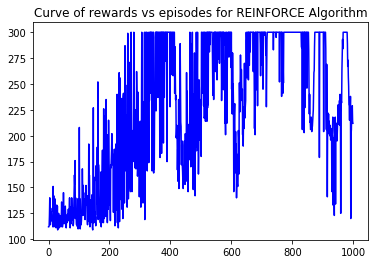

In [5]:
plt.figure()
plt.title('Curve of rewards vs episodes for REINFORCE Algorithm')
plt.plot(episodes, scores, 'b')
plt.show()

##### Inferences:

The policy is learned over 1000 training episodes. We use the curve of episodes v/s rewards as a performance index; The trend shows that the agent learns the policy gradually. It performs well as time progresses.

There are a few instances wherein the policy re-evaluates the log probabilities and reward values in between, and finds an optimum policy again by the end. This is shown by the sudden high and rise in rewards values during the intermediate training.

## Part 2 - Advantage Actor Critic (A2C) Implementation

### Defining the A2C Agent class.

#### Actor: Input - state, Output - Probability of each action
#### Critic: Input - state, Output - Value of state

In [6]:
class A2C:
    # Initializing the parameters of the agent
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        # defining hyperparameters
        self.gamma = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005
        
        # create the models for Actor and Critic
        self.actor_model = self._build_model(self.actor_lr, 'actor')
        self.critic_model = self._build_model(self.critic_lr, 'critic')
        
    # Define the model development function for learning
    def _build_model(self, lr, agent_type):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu', kernel_initializer = 'he_uniform'))
        
        activation2 = ''
        loss = ''
        layer2_dim = 0
        
        if agent_type == 'actor':
            activation2 = 'softmax'
            layer2_dim = self.action_size
            loss = 'categorical_crossentropy'
        
        elif agent_type == 'critic':
            activation2 = 'linear'
            layer2_dim = self.value_size
            loss = 'mse'
            
        model.add(Dense(layer2_dim, activation = activation2, kernel_initializer = 'he_uniform'))
        model.summary()
        model.compile(loss=loss, optimizer=Adam(lr = lr))
        
        return model
    
    # defining a stochastic action method for randomly choosing an action
    def action(self, state):
        random_policy = self.actor_model.predict(state, batch_size=1).flatten()
        acts = np.random.choice(self.action_size, 1, p = random_policy)
        
        return acts[0]
    
    # we use previous replay values for discounting rewards to evaluate policy
    def discount(self, done, value, next_value, action, reward):
        value_dim = (1, self.value_size)
        action_dim = (1, self.action_size)
        
        target = np.zeros(value_dim)
        advantages = np.zeros(action_dim)
        
        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.gamma*next_value
            target[0][0] = reward + self.gamma*next_value
            
        return target, advantages
    
    # update the policy network for every episode
    def update_policy(self, state, action, reward, next_state, done):
        value = self.critic_model.predict(state)[0]
        next_value = self.critic_model.predict(next_state)[0]
        
        target, advantages = self.discount(done, value, next_value, action, reward)
        
        self.actor_model.fit(state, advantages, epochs=1, verbose=0)
        self.critic_model.fit(state, target, epochs=1, verbose=0)

### Setting up the environment. Environment used - CartPole

In [7]:
env = gym.make('CartPole-v0')

# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_shape = [1, state_size]

max_episodes = 1000
max_steps = 5000 

# make A2C agent
agent = A2C(state_size, action_size)

scores = []
episodes = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


### Begin the agent's learning on A2C algorithm for some episodes 

In [8]:
for e in range(max_episodes):
     # initial setup before every episode
    state = env.reset().reshape(state_shape)
    score = 0
    done = 0
    
    for step in range(max_steps):
#         env.render()
        
        # perform a random action from the current state
        action = agent.action(state)
        
        # get the next possible environment values based on the action taken
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape(state_shape)
        
        # making the agent learn using replay values in every episode
        agent.update_policy(state, action, reward, next_state, done)
        
        # update the current score for learning
        score += reward
        
        if done:
            # reset rewards after done
            reward = -100
            
            if score != 500: 
                score += 100
            
            scores.append(score)
            episodes.append(e)
            
#             if e%50 == 0:
            print("episode:", e, "  score:", score)
            
            if np.mean(scores[-min(10,len(scores)):]) > 490:
                exit()
            
            break
            
        # update the state
        state = next_state 

episode: 0   score: 113.0
episode: 1   score: 121.0
episode: 2   score: 115.0
episode: 3   score: 113.0
episode: 4   score: 120.0
episode: 5   score: 113.0
episode: 6   score: 127.0
episode: 7   score: 110.0
episode: 8   score: 115.0
episode: 9   score: 114.0
episode: 10   score: 116.0
episode: 11   score: 120.0
episode: 12   score: 116.0
episode: 13   score: 115.0
episode: 14   score: 112.0
episode: 15   score: 111.0
episode: 16   score: 112.0
episode: 17   score: 124.0
episode: 18   score: 118.0
episode: 19   score: 110.0
episode: 20   score: 123.0
episode: 21   score: 139.0
episode: 22   score: 123.0
episode: 23   score: 122.0
episode: 24   score: 125.0
episode: 25   score: 113.0
episode: 26   score: 122.0
episode: 27   score: 119.0
episode: 28   score: 117.0
episode: 29   score: 134.0
episode: 30   score: 108.0
episode: 31   score: 110.0
episode: 32   score: 113.0
episode: 33   score: 123.0
episode: 34   score: 122.0
episode: 35   score: 122.0
episode: 36   score: 111.0
episode: 37

episode: 297   score: 170.0
episode: 298   score: 171.0
episode: 299   score: 180.0
episode: 300   score: 254.0
episode: 301   score: 159.0
episode: 302   score: 169.0
episode: 303   score: 175.0
episode: 304   score: 177.0
episode: 305   score: 171.0
episode: 306   score: 169.0
episode: 307   score: 154.0
episode: 308   score: 165.0
episode: 309   score: 196.0
episode: 310   score: 178.0
episode: 311   score: 147.0
episode: 312   score: 148.0
episode: 313   score: 151.0
episode: 314   score: 134.0
episode: 315   score: 140.0
episode: 316   score: 151.0
episode: 317   score: 138.0
episode: 318   score: 174.0
episode: 319   score: 154.0
episode: 320   score: 154.0
episode: 321   score: 151.0
episode: 322   score: 132.0
episode: 323   score: 130.0
episode: 324   score: 125.0
episode: 325   score: 165.0
episode: 326   score: 159.0
episode: 327   score: 155.0
episode: 328   score: 146.0
episode: 329   score: 142.0
episode: 330   score: 157.0
episode: 331   score: 124.0
episode: 332   score

episode: 590   score: 300.0
episode: 591   score: 300.0
episode: 592   score: 240.0
episode: 593   score: 195.0
episode: 594   score: 191.0
episode: 595   score: 212.0
episode: 596   score: 211.0
episode: 597   score: 209.0
episode: 598   score: 214.0
episode: 599   score: 191.0
episode: 600   score: 200.0
episode: 601   score: 197.0
episode: 602   score: 196.0
episode: 603   score: 184.0
episode: 604   score: 203.0
episode: 605   score: 204.0
episode: 606   score: 196.0
episode: 607   score: 150.0
episode: 608   score: 211.0
episode: 609   score: 182.0
episode: 610   score: 190.0
episode: 611   score: 196.0
episode: 612   score: 140.0
episode: 613   score: 191.0
episode: 614   score: 202.0
episode: 615   score: 134.0
episode: 616   score: 127.0
episode: 617   score: 185.0
episode: 618   score: 131.0
episode: 619   score: 182.0
episode: 620   score: 192.0
episode: 621   score: 179.0
episode: 622   score: 201.0
episode: 623   score: 184.0
episode: 624   score: 201.0
episode: 625   score

episode: 883   score: 188.0
episode: 884   score: 282.0
episode: 885   score: 224.0
episode: 886   score: 218.0
episode: 887   score: 190.0
episode: 888   score: 181.0
episode: 889   score: 300.0
episode: 890   score: 264.0
episode: 891   score: 195.0
episode: 892   score: 216.0
episode: 893   score: 300.0
episode: 894   score: 294.0
episode: 895   score: 273.0
episode: 896   score: 300.0
episode: 897   score: 300.0
episode: 898   score: 211.0
episode: 899   score: 179.0
episode: 900   score: 169.0
episode: 901   score: 169.0
episode: 902   score: 186.0
episode: 903   score: 184.0
episode: 904   score: 175.0
episode: 905   score: 169.0
episode: 906   score: 209.0
episode: 907   score: 217.0
episode: 908   score: 170.0
episode: 909   score: 287.0
episode: 910   score: 173.0
episode: 911   score: 231.0
episode: 912   score: 171.0
episode: 913   score: 178.0
episode: 914   score: 153.0
episode: 915   score: 157.0
episode: 916   score: 202.0
episode: 917   score: 202.0
episode: 918   score

## Results - 
### Plotting the graphs

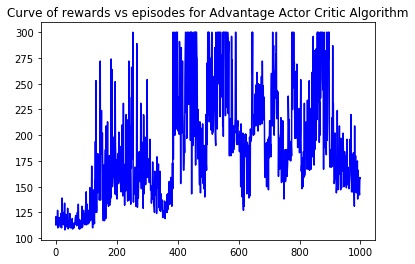

In [9]:
plt.figure()
plt.title('Curve of rewards vs episodes for Advantage Actor Critic Algorithm')
plt.plot(episodes, scores, 'b')
plt.show()

##### Inferences:

The advantage actor critic works by deciding how much better it is to take a specific action compared to the average general action at the given state.Instead of having the critic to learn the Q values, we make it learn the Advantage values. That way the evaluation of an action is based not only on how good the action is, but also how much better it can be. 

The A2C agent gradually learns the better policy and at a rate faster than that of REINFORCE for 1000 episodes.

### Which is the better learning method?


The A2C is a better learning method and it converges faster than the REINFORCE method. The A2C works on both value-function and policy gradient, revalidating the global maximas to ensure the policy is the best policy. The added benefit of using the advantageous A2C method is that it reduces the high variance of policy networks and stabilizes the model on top of using the double validation to find the policy.

## Acknowledgment

Would like to thank Alina for the very insightful course and its implementation.

## References


* https://github.com/simoninithomas/reinforcement-learning-1/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py
* https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c
* https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
* https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

* https://www.freecodecamp.org/news/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f/
* https://github.com/simoninithomas/reinforcement-learning-1/tree/master/2-cartpole/3-reinforce
* https://sergioskar.github.io/Actor_critics/